# Oil Spill Classification

Many imbalanced classification tasks require a skillful model that predicts a crisp class label,
where both classes are equally important. An example of an imbalanced classification problem
where a class label is required and both classes are equally important is the detection of oil spills
or slicks in satellite images. The detection of a spill requires mobilizing an expensive response,
and missing an event is equally expensive, causing damage to the environment.

One way to evaluate imbalanced classification models that predict crisp labels is to calculate
the separate accuracy on the positive class and the negative class, referred to as sensitivity and
specificity. These two measures can then be averaged using the geometric mean, referred to as
the G-mean, that is insensitive to the skewed class distribution and correctly reports on the
skill of the model on both classes. In this tutorial, I have explored how to develop a model to
predict the presence of an oil spill in satellite images and evaluate it using the G-mean metric.

### This notebook is divided into five parts; they are:

1. [Oil Spill Dataset](#Oil-Spill-Dataset)
2. [Explore the Dataset](#Explore-the-Dataset)
3. [Model Test and Baseline Result](#Model-Test-and-Baseline-Result)
4. [Evaluate Models](#Evaluate-Models)
5. [Make Prediction on New Data](#Make-Prediction-on-New-Data)

## Oil Spill Dataset

In this project, we will use a standard imbalanced machine learning dataset referred to as the
oil spill dataset, oil slicks dataset or simply oil. The dataset was introduced in the 1998 paper
by Miroslav Kubat, et al. titled Machine Learning for the Detection of Oil Spills in Satellite
Radar Images. The dataset is often credited to Robert Holte, a co-author of the paper. The
dataset was developed by starting with satellite images of the ocean, some of which contain an
oil spill and some that do not. Images were split into sections and processed using computer
vision algorithms to provide a vector of features to describe the contents of the image section or
patch.

In the task, a model is given a vector that describes the contents of a patch of a satellite
image, then predicts whether the patch contains an oil spill or not, e.g. from the illegal or
accidental dumping of oil in the ocean. There are 937 cases. Each case is comprised of 48
numerical computer vision derived features, a patch number, and a class label.

A total of nine satellite images were processed into patches. Cases in the dataset are ordered
by image and the rst column of the dataset represents the patch number for the image. This
was provided for the purposes of estimating model performance per-image. In this case, we are
not interested in the image or patch number and this first column can be removed. The normal
case is no oil spill assigned the class label of 0, whereas an oil spill is indicated by a class label
of 1. There are 896 cases for no oil spill and 41 cases of an oil spill.

**Dataset**: https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv

## Explore the Dataset

In [1]:
# compare probabilistic model on the oil spill dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from imblearn.metrics import geometric_mean_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [28]:
from collections import Counter
from sklearn.dummy import DummyClassifier

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [65]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

In [22]:
# load the csv file as a data frame
dataframe = read_csv(full_path, header=None)

In [12]:
# summarize the shape of the dataset
print(dataframe.shape)

(937, 47)


In [25]:
# summarize the class distribution
target = dataframe.values[:,-1]

In [26]:
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%


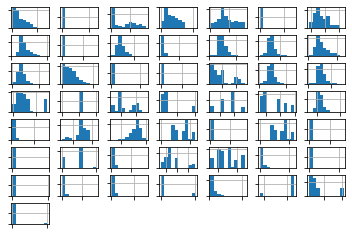

In [24]:
# create a histogram plot of each variable
ax = dataframe.hist()
# disable axis labels
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

## Model Test and Baseline Result

We will evaluate candidate models using repeated stratified k-fold cross-validation. The k-fold
cross-validation procedure provides a good general estimate of model performance that is not too
optimistically biased, at least compared to a single train-test split. We will use k=10, meaning
each fold will contain about 937/10 or about 94 examples. Stratified means that each fold will
contain the same mixture of examples by class, that is about 96% to 4% non-spill and spill.
Repeated means that the evaluation process will be performed multiple times to help avoid 
fluke results and better capture the variance of the chosen model. We will use three repeats. This
means a single model will be fit and evaluated 10 x 3 (30) times and the mean and standard
deviation of these runs will be reported.

This can be achieved using the RepeatedStratifiedKFold scikit-learn class. We are pre-
dicting class labels of whether a satellite image patch contains a spill or not. There are many
measures we could use, although the authors of the paper chose to report the sensitivity,
specificity, and the geometric mean of the two scores, called the G-mean.

The sensitivity is a measure of the accuracy for the positive class and specificity
is a measure of the accuracy of the negative class. The G-mean seeks a balance of these scores,
the geometric mean, where poor performance for one or the other results in a low G-mean score. We can calculate the G-mean for a set of predictions made by a model using the geometric mean score() function provided by the imbalanced-learn
library. First, we can define a function to load the dataset and split the columns into input and
output variables. We will also drop column 22 because the column contains a single value, and
the first column that defines the image patch number. The ``load_dataset()`` function below
implements this.

In [15]:
# load the dataset
def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # drop unused columns
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

We can then define a function that will evaluate a given model on the dataset and return a list
of G-mean scores for each fold and repeat. The ``evaluate_model()`` function below implements
this, taking the dataset and model as arguments and returning the list of scores.

In [3]:
# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

Finally, we can evaluate a baseline model on the dataset using this test harness. A model that
predicts the majority class label (0) or the minority class label (1) for all cases will result in a
G-mean of zero. As such, a good default strategy would be to randomly predict one class label or
another with a 50% probability and aim for a G-mean of about 0.5. This can be achieved using the DummyClassifier class from the scikit-learn library and setting the strategy argument to
``uniform``.

In [36]:
# define the reference model
model = DummyClassifier(strategy='uniform')

Once the model is evaluated, we can report the mean and standard deviation of the G-mean
scores directly.

In [37]:
# define the location of the dataset
full_path = 'oil-spill.csv'

In [38]:
# load the dataset
X, y = load_dataset(full_path)

In [41]:
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean G-mean: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean G-mean: 0.461 (0.134)


Above code first loads and summarizes the dataset. We can see that we have the
correct number of rows loaded, and that we have 47 computer vision derived input variables,
with the constant value column (index 22) and the patch number column (index 0) removed.
Importantly, we can see that the class labels have the correct mapping to integers with 0 for
the majority class and 1 for the minority class, customary for imbalanced binary classification
dataset. Next, the average of the G-mean scores is reported.

In this case, we can see that the baseline algorithm achieves a G-mean of about 0.47, close to
the theoretical maximum of 0.5. This score provides a lower limit on model skill; any model that
achieves an average G-mean above about 0.47 (or really above 0.5) has skill, whereas models
that achieve a score below this value do not have skill on this dataset.

## Evaluate Models

### 1. Evaluate Probabilistic Models

Let's start by evaluating some probabilistic models on the dataset. Probabilistic models are
those models that are fit on the data under a probabilistic framework and often perform well
in general for imbalanced classification datasets. We will evaluate the following probabilistic
models with default hyperparameters in the dataset:

1. Logistic Regression (LR)

2. Linear Discriminant Analysis (LDA)

3. Gaussian Naive Bayes (NB)

Both LR and LDA are sensitive to the scale of the input variables, and often expect and/or
perform better if input variables with different scales are normalized or standardized as a
pre-processing step. In this case, we will standardize the dataset prior to fitting each model.
This will be achieved using a Pipeline and the StandardScaler class. The use of a Pipeline
ensures that the StandardScaler is fit on the training dataset and applied to the train and
test sets within each k-fold cross-validation evaluation, avoiding any data leakage that might
result in an optimistic result. We can define a function to create the models to evaluate on our
test harness as follows:

In [4]:
# define models to test
def get_models():
    models, names = list(), list()
    # LR
    steps = [('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]
    models.append(Pipeline(steps=steps))
    names.append('LR')
    # LDA
    steps = [('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]
    models.append(Pipeline(steps=steps))
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    return models, names

In [7]:
# define models
models, names = get_models()

Once defined, we can enumerate the list and evaluate each in turn. The mean and standard
deviation of G-mean scores can be printed during evaluation and the sample of scores can be
stored. Algorithms can be compared directly based on their mean G-mean score.

In [8]:
# evaluate each model
results = list()
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>LR 0.672 (0.203)
>LDA 0.755 (0.147)
>NB 0.707 (0.202)


At the end of the run, we can use the scores to create a box and whisker plot for each
algorithm. Creating the plots side by side allows the distributions to be compared both with
regard to the mean score, but also the middle 50 percent of the distribution between the 25th
and 75th percentiles.

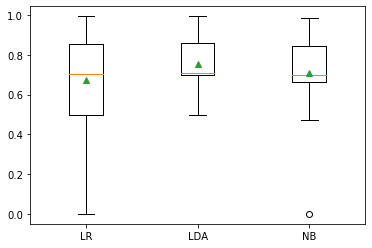

In [9]:
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In this case, we can see that each algorithm has
skill, achieving a mean G-mean above 0.5. The results suggest that an LDA might be the best
performing of the models tested.

The distribution of the G-mean scores is summarized using a figure with a box and whisker
plot for each algorithm. We can see that the distribution for both LDA and NB is compact and skillful and that the LR may have a few results during the run where the method performed
poorly, pushing the distribution down. This highlights that it is not just the mean performance,
but also the consistency of the model that should be considered when selecting a model.

### 2. Evaluate Balanced Logistic Regression

The logistic regression algorithm supports a modification that adjusts the importance of
classification errors to be inversely proportional to the class weighting. This allows the model
to better learn the class boundary in favor of the minority class, which might help overall
G-mean performance. We can achieve this by setting the ``class_weight`` argument of the
``LogisticRegression`` to ``balanced``.

In [42]:
LogisticRegression(solver='liblinear', class_weight='balanced')

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Logistic regression is sensitive to the scale of input variables and can perform
better with normalized or standardized inputs; as such it is a good idea to test both for a given
dataset. Additionally, a power distribution can be used to spread out the distribution of each input variable and make those variables with a Gaussian-like distribution more Gaussian. This
can benefit models like Logistic Regression that make assumptions about the distribution of
input variables.

The power transform will use the Yeo-Johnson method that supports positive and negative
inputs, but we will also normalize data prior to the transform. Also, the ``PowerTransformer``
class used for the transform will also standardize each variable after the transform. We will
compare a ``LogisticRegression`` with a balanced class weighting to the same algorithm with
three difierent data preparation schemes, specifically normalization, standardization, and a
power transform.

In [44]:
# define models to test
def get_models():
    models, names = list(), list()
    # LR Balanced
    models.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
    names.append('Balanced')
    # LR Balanced + Normalization
    steps = [('t',MinMaxScaler()), ('m', LogisticRegression(solver='liblinear',
    class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Norm')
    # LR Balanced + Standardization
    steps = [('t',StandardScaler()), ('m', LogisticRegression(solver='liblinear',
    class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Std')
    # LR Balanced + Power
    steps = [('t1',MinMaxScaler()), ('t2',PowerTransformer()), ('m',
    LogisticRegression(solver='liblinear', class_weight='balanced'))]
    models.append(Pipeline(steps=steps))
    names.append('Balanced-Power')
    return models, names

In [49]:
# define models
models, names = get_models()
# evaluate each model
results = list()
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>Balanced 0.843 (0.123)
>Balanced-Norm 0.836 (0.088)
>Balanced-Std 0.834 (0.129)
>Balanced-Power 0.862 (0.124)


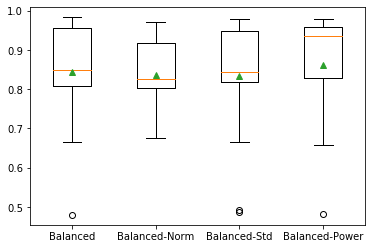

In [50]:
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In this case, we can see that the balanced version of logistic regression performs much better
than all of the probabilistic models evaluated in the previous section. The results suggest that
perhaps the use of balanced LR with data normalization for pre-processing performs the best
on this dataset with a mean G-mean score of about 0.852.

We can see that the distribution for the balanced LR is tighter in
general than the non-balanced version in the previous section. We can also see that the median
result (orange line) for the normalized version is higher than the mean, above 0.9, which is
impressive. A mean different from the median suggests a skewed distribution for the results,
pulling the mean down with a few bad outcomes.

### 3. Evaluate Data Sampling With Probabilistic Models

Data sampling provides a way to better prepare the imbalanced training dataset prior to fitting
a model. Perhaps the most popular data sampling is the **SMOTE** oversampling technique for
creating new synthetic examples for the minority class. This can be paired with the edited
nearest neighbor (ENN) algorithm that will locate and remove examples from the dataset that
are ambiguous, making it easier for models to learn to discriminate between the two classes.
This combination is called **SMOTE-ENN** and can be implemented using the ``SMOTEENN`` class
from the imbalanced-learn library; for example:

In [54]:
# define SMOTE-ENN data sampling method
e = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

**SMOTE** and **ENN**
both work better when the input data is scaled beforehand. This
is because both techniques involve using the nearest neighbor algorithm internally and this
algorithm is sensitive to input variables with different scales. Therefore, we will require the data to be normalized as a first step, then sampled, then used as input to the (unbalanced) logistic
regression model. As such, we can use the Pipeline class provided by the imbalanced-learn
library to create a sequence of data transforms including the data sampling method, and ending
with the logistic regression model. We will compare four variations of the logistic regression
model with data sampling, specifically:

i. SMOTEENN + LR

ii. Normalization + SMOTEENN + LR

iii. Standardization + SMOTEENN + LR

iv. Normalization + Power + SMOTEENN + LR

The expectation is that LR will perform better with SMOTEENN, and that SMOTEENN
will perform better with standardization or normalization. The last case does a lot, first
normalizing the dataset, then applying the power transform, standardizing the result (the PowerTransformer class will standardize the output by default), applying SMOTEENN,
then finally fitting a logistic regression model. These combinations can be defined as follows:



In [63]:
# define models to test
def get_models():
    models, names = list(), list()
    # SMOTEENN
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('LR')
    # SMOTEENN + Norm
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', MinMaxScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Norm')
    # SMOTEENN + Std
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t', StandardScaler()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('Std')
    # SMOTEENN + Power
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = LogisticRegression(solver='liblinear')
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m',
    model)]
    models.append(Pipeline(steps=steps))
    names.append('Power')
    return models, names

In [66]:
# define models
models, names = get_models()
# evaluate each model
results = list()
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    results.append(scores)

>LR 0.862 (0.094)
>Norm 0.829 (0.089)
>Std 0.830 (0.122)
>Power 0.883 (0.121)


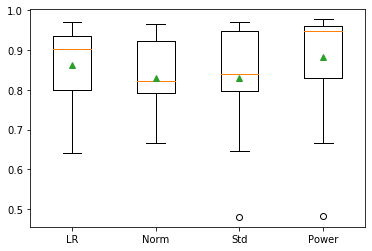

In [67]:
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In this case, we can see that the addition of SMOTEENN improves the performance of the
default LR algorithm, achieving a mean G-mean of 0.852 compared to 0.621 seen in the rst
set of experimental results. This is even better than balanced LR without any data scaling
(previous section) that achieved a G-mean of about 0.846.

The results suggest that perhaps the final combination of normalization, power transform,
and standardization achieves a slightly better score than the default LR with SMOTEENN with
a G-mean of about 0.873.

The distribution of results can be compared with box and whisker plots. We can see the
distributions all roughly have the same tight spread and that the difference in means of the
results can be used to select a model.

## Make Prediction on New Data

The use of SMOTEENN with Logistic Regression directly without any data scaling probably
provides the simplest and well-performing model that could be used going forward. This model
had a mean G-mean of about 0.852 on our test harness. We will use this as our final model and
use it to make predictions on new data. First, we can define the model as a pipeline.

In [70]:
# define the model
smoteenn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
model = LogisticRegression(solver='liblinear')
pipeline = Pipeline(steps=[('e', smoteenn), ('m', model)])

In [80]:
import pandas as pd
pd.DataFrame(data)


,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,329,1627.54,1409.43,51,822500,35.00,6.10,4610,0.17,178.4,...,55,1460.31,710.63,451.78,150.85,3.23,0,4530.75,66.25,7.85
1,3234,1091.56,1357.96,32,8085000,40.08,8.98,25450,0.22,317.7,...,55,4287.77,3095.56,1937.42,773.69,2.21,0,4927.51,66.15,7.24
2,2339,1537.68,1633.02,45,5847500,38.13,9.29,22110,0.24,264.5,...,55,3959.80,2404.16,1530.38,659.67,2.59,0,4732.04,66.34,7.67


Once fit, we can use it to make predictions for new data by calling the ``predict()`` function.
This will return the class label of 0 for no oil spill, or 1 for an oil spill. For example:

In [81]:
# evaluate on some non-spill cases (known class 0)
print('Non-Spill Cases:')
data = [[1627.54, 1409.43, 51, 822500, 35, 6.1, 4610, 0.17, 178.4, 0.2, 0.24, 0.39,
0.12, 0.27, 138.32, 34.81, 2.02, 0.14, 0.19, 75.26, 0, 0.47, 351.67, 0.18, 9.24, 0.38,
2.57, -2.96, -0.28, 1.93, 0, 1.93, 34, 1710, 0, 25.84, 78, 55, 1460.31, 710.63, 451.78,
150.85, 3.23, 0, 4530.75, 66.25, 7.85],
[1091.56, 1357.96, 32, 8085000, 40.08, 8.98, 25450, 0.22, 317.7, 0.18, 0.2, 0.49,
0.09, 0.41, 114.69, 41.87, 2.31, 0.15, 0.18, 75.26, 0, 0.53, 351.67, 0.18, 9.24,
0.24, 3.56, -3.09, -0.31, 2.17, 0, 2.17, 281, 14490, 0, 80.11, 78, 55, 4287.77,
3095.56, 1937.42, 773.69, 2.21, 0, 4927.51, 66.15, 7.24],
[1537.68, 1633.02, 45, 5847500, 38.13, 9.29, 22110, 0.24, 264.5, 0.21, 0.26, 0.79,
0.08, 0.71, 89.49, 32.23, 2.2, 0.17, 0.22, 75.26, 0, 0.51, 351.67, 0.18, 9.24, 0.27,
4.21, -2.84, -0.29, 2.16, 0, 2.16, 228, 12150, 0, 83.6, 78, 55, 3959.8, 2404.16,
1530.38, 659.67, 2.59, 0, 4732.04, 66.34, 7.67]]

for row in data:
    # make prediction
    yhat = pipeline.predict([row])
    # get the label
    label = yhat[0]
    # summarize
    print('>Predicted=%d (expected 0)' % (label))

Non-Spill Cases:
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)
>Predicted=0 (expected 0)


In [85]:
print('Spill Cases:')
data = [[1020.91, 630.8, 59, 7427500, 32.76, 10.48, 17380, 0.32, 427.4, 0.22, 0.29,
0.5, 0.08, 0.42, 149.87, 50.99, 1.89, 0.14, 0.18, 75.26, 0, 0.44, 351.67, 0.18, 9.24,
2.5, 10.63, -3.07, -0.28, 2.18, 0, 2.18, 164, 8730, 0, 40.67, 78, 55, 5650.88, 1749.29,
1245.07, 348.7, 4.54, 0, 25579.34, 65.78, 7.41],
[1118.08, 469.39, 11, 7887500, 30.41, 7.99, 15880, 0.26, 496.7, 0.2, 0.26, 0.69,
0.11, 0.58, 118.11, 43.96, 1.76, 0.15, 0.18, 75.26, 0, 0.4, 351.67, 0.18, 9.24, 0.78,
8.68, -3.19, -0.33, 2.19, 0, 2.19, 150, 8100, 0, 31.97, 78, 55, 3471.31, 3059.41,
2043.9, 477.23, 1.7, 0, 28172.07, 65.72, 7.58],
[1449.85, 608.43, 88, 287500, 40.42, 7.34, 3340, 0.18, 86.1, 0.21, 0.32, 0.5, 0.17,
0.34, 71.2, 16.73, 1.82, 0.19, 0.29, 87.65, 0, 0.46, 132.78, -0.01, 3.78, 0.7, 4.79,
-3.36, -0.23, 1.95, 0, 1.95, 29, 1530, 0.01, 38.8, 89, 69, 1400, 250, 150, 45.13,
9.33, 1, 31692.84, 65.81, 7.84]]
for row in data:
    # make prediction
    yhat = pipeline.predict([row])
    # get the label
    label = yhat[0]
    # summarize
    print('>Predicted=%d (expected 1)' % (label))

Spill Cases:
>Predicted=0 (expected 1)
>Predicted=0 (expected 1)
>Predicted=0 (expected 1)


Running the example first fits the model on the entire training dataset. Then the fit model
used to predict the label of an oil spill for cases where we know there is none, chosen from the
dataset file. We can see that all cases are correctly predicted. Then some cases of actual oil
spills are used as input to the model and the label is predicted. As we might have hoped, the
correct labels are again predicted.